### Import and authentification

In [1]:
import ee 
import folium
from datetime import datetime as dt
from IPython.display import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
ee.Initialize()
ee.Authenticate()

Enter verification code: 4/1AY0e-g7KnjEVDIY81fxQzVyOP9Y00LTNpGaf2pfOXjm9q8qYk8bom2rA9Bs

Successfully saved authorization token.


### Global variables

In [58]:
import os
from google.cloud import storage

BUCKET = 'forest_guard_bucket'  # ⚠️ replace with your BUCKET NAME 
FOLDER = 'ARTHUR_feature_engineering_2'
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

OPTICAL_BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
THERMAL_BANDS = ['B10', 'B11']
BANDS = OPTICAL_BANDS + THERMAL_BANDS
RESPONSE = 'fnf'
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]

COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Specify model training parameters.
BATCH_SIZE = 16
# EPOCHS = 10
BUFFER_SIZE = 2000
# OPTIMIZER = 'SGD'
# LOSS = 'MeanSquaredError'
# METRICS = ['RootMeanSquaredError']
   

### Data

#### X

In [4]:
# Use Landsat 8 surface reflectance data.
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

# Cloud masking function from GEE
def maskL8sr(image):
    cloudShadowBitMask = ee.Number(2).pow(3).int()
    cloudsBitMask = ee.Number(2).pow(5).int()
    qa = image.select('pixel_qa')
    mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
      qa.bitwiseAnd(cloudsBitMask).eq(0))
    mask2 = image.mask().reduce('min')
    mask3 = image.select(OPTICAL_BANDS).gt(0).And(
            image.select(OPTICAL_BANDS).lt(10000)).reduce('min')
    mask = mask1.And(mask2).And(mask3)
    return image.select(OPTICAL_BANDS).divide(10000).addBands(
            image.select(THERMAL_BANDS).divide(10).clamp(273.15, 373.15)
              .subtract(273.15).divide(100)).updateMask(mask)

# The image input data is a cloud-masked median composite.
image = l8sr.filterDate('2015-01-01', '2017-12-31').map(maskL8sr).median()

# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[48.9, 2.5])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
    opacity = 0.5
  ).add_to(map)

mapid = image.getMapId({'bands': ['B11'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal',
    opacity = 0.5
  ).add_to(map)
map.add_child(folium.LayerControl())
map

#### Target

In [59]:
jaxa = ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/FNF').filterDate('2015-01-01', '2017-12-31').median()

jaxa_norm = jaxa.divide(100).float()

palette = ['006400',
           'FEFF99',
         #  '0000FF'
          ]
mapid = jaxa.getMapId({'bands': ['fnf'],
                       'min': 1, 
                       'max': 2, 
                      'palette':palette
                      })
map = folium.Map(location=[48.9, 2.5])


folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='jaxa fnf',
    color=palette,
    opacity = 1
  ).add_to(map)
map.add_child(folium.LayerControl())
map

### Stacking X and y

In [60]:

featureStack = ee.Image.cat([
  image.select(BANDS),
  jaxa.select(RESPONSE)
]).float()

list = ee.List.repeat(1, KERNEL_SIZE)
lists = ee.List.repeat(list, KERNEL_SIZE)
kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, lists)

arrays = featureStack.neighborhoodToArray(kernel)

### Areas of interests

In [7]:
# create our own areas of interests
# training features collection
rect_train = ee.Geometry.Rectangle([3.327248985602229, 46.600827791084875, 4.689553673102229,47.70649093701327])
trainingPolys = ee.FeatureCollection([rect_train])
# eval features collections
rect_eval = ee.Geometry.Rectangle([-0.7016469211726672,46.88962161312492, 0.9353159694523328,47.64998631126759])
evalPolys= ee.FeatureCollection([rect_eval])

In [68]:
# create our own areas of interests
# training features collection
rect_train_2 = ee.Geometry.Rectangle([-3.3322638872392663, 46.018501274019656, 1.8532829877607337,47.538140979662714])
trainingPolys_2 = ee.FeatureCollection([rect_train_2])
# eval features collections
rect_eval_2 = ee.Geometry.Rectangle([-4.019787418788643,42.60854105407055, 0.6384157062113571,45.219627477903565])
evalPolys_2= ee.FeatureCollection([rect_eval_2])

In [69]:
###################################################
###   DEFINE OUR COLLECTSIONS OF AREAS OF INTEREST
################################################
# trainingPolys = ee.FeatureCollection('projects/google/DemoTrainingGeometries')
# evalPolys = ee.FeatureCollection('projects/google/DemoEvalGeometries')

polyImage = ee.Image(0).byte().paint(trainingPolys_2, 1).paint(evalPolys_2, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['red', 'blue']})
map = folium.Map(location=[47., 0.], zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [70]:
trainingPolysList = trainingPolys_2.toList(trainingPolys_2.size())
evalPolysList = evalPolys_2.toList(evalPolys_2.size())

In [72]:
print(ee.Feature(trainingPolysList.get(0)).geometry())

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "List.get",
          "arguments": {
            "index": {
              "constantValue": 0
            },
            "list": {
              "functionInvocationValue": {
                "functionName": "Collection.toList",
                "arguments": {
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "Collection",
                      "arguments": {
                        "features": {
                          "arrayValue": {
                            "values": [
                              {
                                "functionInvocationValue": {
                                  "functionName": "Feature",
                                  "arguments": {
                                    "geometry": {
            

### Export data TFRecords

In [73]:
# Convert the feature collections to lists for iteration.
trainingPolysList = trainingPolys_2.toList(trainingPolys_2.size())
evalPolysList = evalPolys_2.toList(evalPolys_2.size())

# These numbers determined experimentally.
n = 2 # Number of shards in each polygon.
N = 20 # Total sample size in each polygon.

# Export all the training data (in many pieces), with one task 
# per geometry.
for g in range(trainingPolys_2.size().getInfo()):
    geomSample = ee.FeatureCollection([])
    for i in range(n):
        print(i)
        sample = arrays.sample(
          region = ee.Feature(trainingPolysList.get(g)).geometry(), 
          scale = 30,
          numPixels = N / n, # Size of the shard.
          seed = i,
          tileScale = 8
        )
        geomSample = geomSample.merge(sample)

    desc = TRAINING_BASE + '_g' + str(g)

    
    task = ee.batch.Export.table.toCloudStorage(
                                                collection = geomSample,
                                                description = desc,
                                                bucket = BUCKET,
                                                fileNamePrefix = FOLDER + '/' + desc,
                                                fileFormat = 'TFRecord',
                                                selectors = BANDS + [RESPONSE], 
                                                )
    task.start()
    print('g : ' , g)
    
    
# Monitor task progress
# Code Extracted here:
# https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/TF_demo1_keras.ipynb
# import time 
# while task.active():
#   print('Polling for task (id: {}).'.format(task.id))
#   time.sleep(5)
	
# print('Done!')

# Export all the evaluation data.
for g in range(evalPolys_2.size().getInfo()):
    geomSample = ee.FeatureCollection([])
    for i in range(n):
        sample = arrays.sample(
                              region = ee.Feature(evalPolysList.get(g)).geometry(), 
                              scale = 30,
                              numPixels = N / n,
                              seed = i,
                              tileScale = 8
                            )
        geomSample = geomSample.merge(sample)

desc = EVAL_BASE + '_g' + str(g)
task = ee.batch.Export.table.toCloudStorage(
                                        collection = geomSample,
                                        description = desc,
                                        bucket = BUCKET,
                                        fileNamePrefix = FOLDER + '/' + desc,
                                        fileFormat = 'TFRecord',
                                        selectors = BANDS + [RESPONSE]
                                        )
task.start()
task.status()
# Monitor task progress
# Code Extracted here:
# https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/TF_demo1_keras.ipynb
import time 
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)
task.status()

0
1
g :  0
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling for task (id: 4DF2BKRAZR6OFJY6GMU5EMVG).
Polling f

{'state': 'COMPLETED',
 'description': 'eval_patches_g0',
 'creation_timestamp_ms': 1622041108202,
 'update_timestamp_ms': 1622041510551,
 'start_timestamp_ms': 1622041156582,
 'task_type': 'EXPORT_FEATURES',
 'destination_uris': ['https://console.developers.google.com/storage/browser/forest_guard_bucket/ARTHUR_feature_engineering_2/'],
 'attempt': 1,
 'id': '4DF2BKRAZR6OFJY6GMU5EMVG',
 'name': 'projects/earthengine-legacy/operations/4DF2BKRAZR6OFJY6GMU5EMVG'}

### Parse TFRecords and get back tensors

In [74]:
def parse_tfrecord(example_proto):
    """The parsing function.
    Read a serialized example into the structure defined by FEATURES_DICT.
    Args:
    example_proto: a serialized Example.
    Returns:
    A dictionary of tensors, keyed by feature name.
    """
    return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
    """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Args:
    inputs: A dictionary of tensors, keyed by feature name.
    Returns:
    A tuple of (inputs, outputs).
    """
    inputsList = [inputs.get(key) for key in FEATURES]
    stacked = tf.stack(inputsList, axis=0)
    # Convert from CHW to HWC
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]


def get_dataset(pattern):
    """Function to read, parse and format to tuple a set of input tfrecord files.
    Get all the files matching the pattern, parse and convert to tuple.
    Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
    Returns:
    A tf.data.Dataset
    """
    glob = tf.io.gfile.glob(pattern)
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
    dataset = dataset.map(to_tuple, num_parallel_calls=5)
    return dataset

In [75]:
def get_training_dataset():
    """Get the preprocessed training dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    glob = 'gs://' + BUCKET + '/' + FOLDER + '/' + TRAINING_BASE + '*'
    dataset = get_dataset(glob)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    return dataset

training = get_training_dataset()

print(iter(training.take(1)).next())

(<tf.Tensor: shape=(16, 256, 256, 9), dtype=float32, numpy=
array([[[[0.03025   , 0.03735   , 0.0664    , ..., 0.11845   ,
          0.203     , 0.1835    ],
         [0.02185   , 0.0251    , 0.04995   , ..., 0.08815   ,
          0.1995    , 0.1795    ],
         [0.02185   , 0.0251    , 0.04995   , ..., 0.08815   ,
          0.1995    , 0.1795    ],
         ...,
         [0.0293    , 0.0434    , 0.0806    , ..., 0.1175    ,
          0.1755    , 0.1675    ],
         [0.03025   , 0.0442    , 0.08385   , ..., 0.1265    ,
          0.1785    , 0.1675    ],
         [0.0322    , 0.0465    , 0.0836    , ..., 0.1312    ,
          0.1865    , 0.1675    ]],

        [[0.01666667, 0.02052727, 0.0409    , ..., 0.073825  ,
          0.1955    , 0.179     ],
         [0.0185    , 0.0208    , 0.0395    , ..., 0.069     ,
          0.1945    , 0.1755    ],
         [0.0186    , 0.0208    , 0.03986667, ..., 0.069     ,
          0.1945    , 0.1735    ],
         ...,
         [0.0283    , 0.0422

In [23]:
print(iter(training.take(1)).next())

(<tf.Tensor: shape=(16, 256, 256, 9), dtype=float32, numpy=
array([[[[0.02155   , 0.02405   , 0.0427    , ..., 0.06495   ,
          0.1645    , 0.1505    ],
         [0.0211    , 0.0243    , 0.04475   , ..., 0.06505   ,
          0.1655    , 0.152     ],
         [0.0211    , 0.0243    , 0.04475   , ..., 0.06505   ,
          0.1655    , 0.152     ],
         ...,
         [0.01915   , 0.02265   , 0.0424    , ..., 0.06155   ,
          0.1645    , 0.1485    ],
         [0.01915   , 0.02265   , 0.0424    , ..., 0.06155   ,
          0.1645    , 0.1485    ],
         [0.0169    , 0.0221    , 0.0425    , ..., 0.0619    ,
          0.1645    , 0.1485    ]],

        [[0.0222    , 0.02465   , 0.044     , ..., 0.0691    ,
          0.1645    , 0.1505    ],
         [0.0219    , 0.02405   , 0.0448    , ..., 0.0642    ,
          0.165     , 0.1515    ],
         [0.0219    , 0.02405   , 0.0448    , ..., 0.0642    ,
          0.165     , 0.1515    ],
         ...,
         [0.0288    , 0.0326

In [213]:
def get_eval_dataset():
    """Get the preprocessed evaluation dataset
    Returns: 
    A tf.data.Dataset of evaluation data.
    """
    glob = 'gs://' + BUCKET + '/' + FOLDER + '/' + EVAL_BASE + '*'
    dataset = get_dataset(glob)
    dataset = dataset.batch(1).repeat()
    return dataset

evaluation = get_eval_dataset()

In [214]:
print(iter(evaluation.take(1)).next())

(<tf.Tensor: shape=(1, 256, 256, 9), dtype=float32, numpy=
array([[[[0.0192 , 0.0246 , 0.0411 , ..., 0.0471 , 0.1685 , 0.1475 ],
         [0.0185 , 0.024  , 0.0402 , ..., 0.0462 , 0.1645 , 0.1435 ],
         [0.0185 , 0.024  , 0.0402 , ..., 0.0462 , 0.1645 , 0.1435 ],
         ...,
         [0.01475, 0.0192 , 0.0345 , ..., 0.0489 , 0.178  , 0.159  ],
         [0.01475, 0.0192 , 0.0345 , ..., 0.0489 , 0.178  , 0.159  ],
         [0.0183 , 0.02225, 0.03665, ..., 0.0576 , 0.1795 , 0.1615 ]],

        [[0.02515, 0.03075, 0.04835, ..., 0.06315, 0.1695 , 0.1475 ],
         [0.02785, 0.03375, 0.0539 , ..., 0.0761 , 0.1655 , 0.146  ],
         [0.02785, 0.03375, 0.0539 , ..., 0.0761 , 0.1655 , 0.146  ],
         ...,
         [0.0153 , 0.01955, 0.03335, ..., 0.04795, 0.178  , 0.16   ],
         [0.0153 , 0.01955, 0.03335, ..., 0.04795, 0.178  , 0.16   ],
         [0.01835, 0.02275, 0.0367 , ..., 0.06075, 0.1795 , 0.162  ]],

        [[0.0301 , 0.0371 , 0.05745, ..., 0.0736 , 0.172  , 0.15   ],

### Explore data

In [76]:
type(training)

tensorflow.python.data.ops.dataset_ops.RepeatDataset

In [179]:
training_images , training_labels = iter(training).next()

In [215]:
eval_images , eval_labels = iter(evaluation).next()

In [183]:
training_images.shape

TensorShape([16, 256, 256, 9])

In [182]:
training_images[0,:,:,:].numpy().shape

(256, 256, 9)

In [184]:
training_labels.shape

TensorShape([16, 256, 256, 1])

In [185]:
training_labels[0,:,:,:].numpy().shape

(256, 256, 1)

In [186]:
np.flip(training_images[0, :, : , 1:4], axis=2).numpy()

array([[[0.01155, 0.02115, 0.0279 ],
        [0.0113 , 0.0202 , 0.02805],
        [0.0114 , 0.02115, 0.02825],
        ...,
        [0.0126 , 0.0248 , 0.0279 ],
        [0.01155, 0.02245, 0.028  ],
        [0.01185, 0.02245, 0.0279 ]],

       [[0.011  , 0.0203 , 0.0279 ],
        [0.0106 , 0.022  , 0.0275 ],
        [0.01165, 0.0206 , 0.02815],
        ...,
        [0.01225, 0.02315, 0.02875],
        [0.0118 , 0.0232 , 0.0287 ],
        [0.0123 , 0.0221 , 0.0269 ]],

       [[0.012  , 0.0231 , 0.0282 ],
        [0.0113 , 0.0227 , 0.0282 ],
        [0.01155, 0.0221 , 0.0282 ],
        ...,
        [0.0124 , 0.0235 , 0.02805],
        [0.01235, 0.02325, 0.02765],
        [0.0124 , 0.0231 , 0.0278 ]],

       ...,

       [[0.01265, 0.0262 , 0.03245],
        [0.0128 , 0.02575, 0.032  ],
        [0.0126 , 0.0247 , 0.0328 ],
        ...,
        [0.0145 , 0.0295 , 0.0334 ],
        [0.0132 , 0.0282 , 0.0325 ],
        [0.0132 , 0.0282 , 0.0325 ]],

       [[0.0127 , 0.02705, 0.0322 ],
  

In [187]:
training_images[0, :, : , 1:4].numpy()

array([[[0.0279 , 0.02115, 0.01155],
        [0.02805, 0.0202 , 0.0113 ],
        [0.02825, 0.02115, 0.0114 ],
        ...,
        [0.0279 , 0.0248 , 0.0126 ],
        [0.028  , 0.02245, 0.01155],
        [0.0279 , 0.02245, 0.01185]],

       [[0.0279 , 0.0203 , 0.011  ],
        [0.0275 , 0.022  , 0.0106 ],
        [0.02815, 0.0206 , 0.01165],
        ...,
        [0.02875, 0.02315, 0.01225],
        [0.0287 , 0.0232 , 0.0118 ],
        [0.0269 , 0.0221 , 0.0123 ]],

       [[0.0282 , 0.0231 , 0.012  ],
        [0.0282 , 0.0227 , 0.0113 ],
        [0.0282 , 0.0221 , 0.01155],
        ...,
        [0.02805, 0.0235 , 0.0124 ],
        [0.02765, 0.02325, 0.01235],
        [0.0278 , 0.0231 , 0.0124 ]],

       ...,

       [[0.03245, 0.0262 , 0.01265],
        [0.032  , 0.02575, 0.0128 ],
        [0.0328 , 0.0247 , 0.0126 ],
        ...,
        [0.0334 , 0.0295 , 0.0145 ],
        [0.0325 , 0.0282 , 0.0132 ],
        [0.0325 , 0.0282 , 0.0132 ]],

       [[0.0322 , 0.02705, 0.0127 ],
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


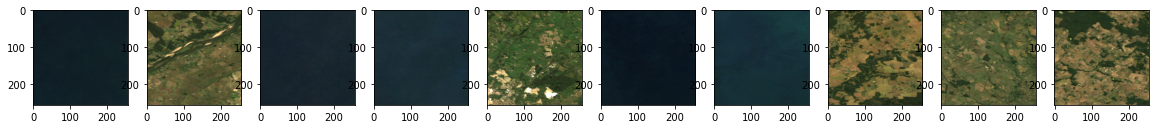

In [188]:
fig = plt.figure(figsize=(20,10))

for i in range(10):
    plt.subplot(1, 10, i+1 )
    plt.imshow(np.flip(training_images[i, :, : , 1:4].numpy(), axis=2)*5)

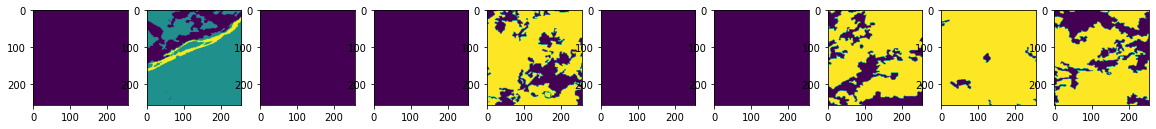

In [189]:
fig = plt.figure(figsize=(20,10))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(training_labels[i, :, : , :])

### Binary target

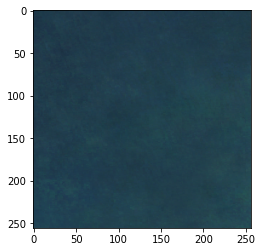

In [190]:
plt.imshow(np.flip(training_images[0, :, : , 1:4].numpy(), axis=2)*10)

In [191]:
np.unique(training_labels[0].numpy())

array([3.], dtype=float32)

In [193]:
np.unique(training_labels.numpy())

array([1., 2., 3.], dtype=float32)

In [194]:
binary_training_labels = np.where(training_labels==3,2,training_labels)

In [195]:
type(binary_training_labels)

numpy.ndarray

In [196]:
binary_training_labels = tf.convert_to_tensor(binary_training_labels)

In [197]:
type(binary_training_labels)

tensorflow.python.framework.ops.EagerTensor

In [198]:
binary_training_labels.shape

TensorShape([16, 256, 256, 1])

In [199]:
np.unique(binary_training_labels)

array([1., 2.], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


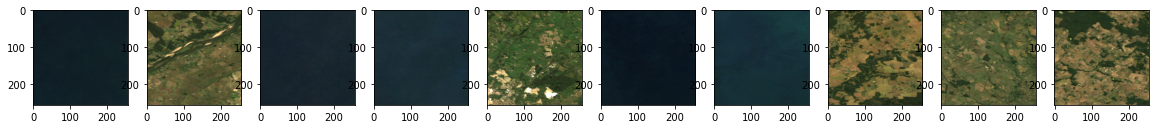

In [205]:
fig = plt.figure(figsize=(20,10))

for i in range(10):
    plt.subplot(1, 10, i+1 )
    plt.imshow(np.flip(training_images[i, :, : , 1:4].numpy(), axis=2)*5)

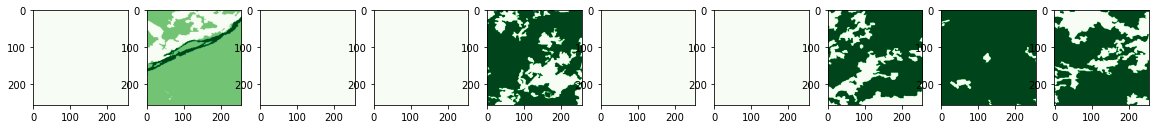

In [201]:
fig = plt.figure(figsize=(20,10))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(training_labels[i, :, : , :],cmap='Greens')

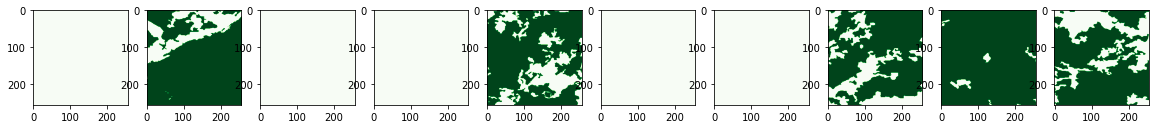

In [202]:
fig = plt.figure(figsize=(20,10))

for i in range(10):
    plt.subplot(1,10,i+1)
    
    plt.imshow(binary_training_labels[i, :, : , :],cmap='Greens')

In [208]:
training_labels[0,100,100,0].numpy()

3.0

In [209]:
training_labels[4,200,200,0].numpy()

1.0

In [212]:
training_labels[1,200,200,0].numpy()

2.0

In [234]:
binary_eval_labels = tf.convert_to_tensor(np.where(eval_labels==3,2,eval_labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


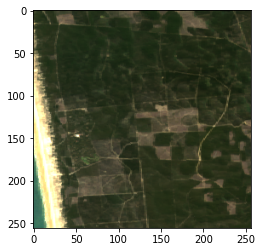

In [230]:
plt.imshow(np.flip(eval_images[0, :, : , 1:4].numpy(), axis=2)*5)

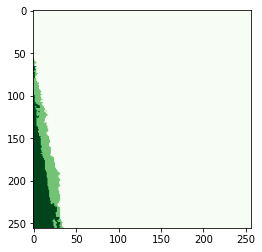

In [221]:
plt.imshow(eval_labels[0, :, : ,0].numpy(),cmap='Greens')

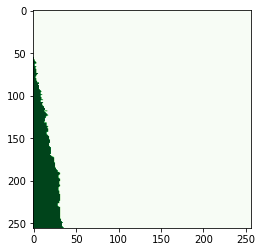

In [233]:
plt.imshow(binary_eval_labels[0, :, : ,0].numpy(),cmap='Greens')

### Adding features

NDVI, a vegetation index computed from reflectance in two spectral bands :

In [235]:
def normalized_difference(a, b):
    """Compute normalized difference of two inputs.
    Compute (a - b) / (a + b).  If the denomenator is zero, add a small delta.
    Args:
      a: an input tensor with shape=[1]
      b: an input tensor with shape=[1]
    Returns:
      The normalized difference as a tensor.
    """
    nd = (a - b) / (a + b)
    nd_inf = (a - b) / (a + b + 0.000001)
    return tf.where(tf.math.is_finite(nd), nd, nd_inf)

def add_NDVI(features, label):
    """Add NDVI to the dataset.
    Args:
      features: a dictionary of input tensors keyed by feature name.
      label: the target label
    Returns:
      A tuple of the input dictionary with an NDVI tensor added and the label.
    """
    features['NDVI'] = normalized_difference(features['B5'], features['B4'])
    return features, label

In [236]:
training_images_2 = training_images.map(add_NDVI)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'map'